### Import libraries and set palette

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [2]:
sns.color_palette("rainbow")

# found a helpful article on sns color palettes here 
#https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f

[(0.21764705882352942, 0.42912060877260894, 0.9755119679804366),
 (0.0725490196078431, 0.7829276104921027, 0.9005867023006374),
 (0.3549019607843137, 0.9741386021045101, 0.7829276104921028),
 (0.6450980392156862, 0.9741386021045102, 0.622112816721474),
 (0.9274509803921569, 0.7829276104921029, 0.43467642176596505),
 (1.0, 0.42912060877260916, 0.2199463578396687)]

In [3]:
sns.set_palette("rainbow")

### Read in and clean data for visualizations

In [4]:
#read in training data

houses = pd.read_csv('../datasets/train.csv')

In [8]:
#data cleaning function feature interaction variables added

def clean_data_added_features(df):
    
    #lowercase columns
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    #ordinal data dictionary 
    ord_dict = {
        'Ex' : 5,
        'Gd' : 4,
        'TA' : 3,
        'Fa' : 2,
        'Po' : 1,
        0    : 0
    }
    
    #basement finish dictionary
    bsmt_fin_dict = {
       'GLQ' : 5,
       'ALQ' : 4, 
       'BLQ' : 3,
       'Rec' : 3,
       'LwQ' : 2,
       'Unf' : 1,
        0    : 0
    }
        
    # fil lot frontage empties with mean value
    lot_frontage_mean = df['lot_frontage'].mean()
    df['lot_frontage'].fillna(lot_frontage_mean, inplace=True)
    
    #fill NA values with 'none' for nominal data when appropriate according to data dictionary
    df['alley'].fillna('None', inplace=True)
    df['mas_vnr_type'].fillna('None', inplace=True)
    df['garage_type'].fillna('None', inplace=True)
    df['misc_feature'].fillna('None', inplace=True)
    
    #ordinal mapping for lot shape
    df['lot_shape'] = df['lot_shape'].map({'Regular': 4, 'IR1': 3 , 'IR2' : 2,  'IR3' : 1})     
    
    #ordinal mapping for utilities
    df['utilities'] = df['utilities'].map({'AllPub': 4, 'NoSeWa': 3 , 'NoSewr' : 2, 'ELO': 1})   
    
     #ordinal mapping for land slope
    df['land_slope'] = df['land_slope'].map({'Gtl': 3, 'NMod': 2 , 'Sev' : 1})     
    
    #ordinal mapping for basement exposure
    df['bsmt_exposure'] = df['bsmt_exposure'].map({'Gd': 3, 'Av': 2 , 'Mn' : 1, 'No': 0})     
    
    #ordinal mapping for electrical
    df['electrical'] = df['electrical'].map({'SBrkr': 4, 'FuseA': 3 , 'FuseF' : 2, 'FuseP': 1, 'Mix' : 2})    
    
    #ordinal mapping for functional
    df['functional'] = df['functional'].map({'Typ': 5, 'Min1':4 , 'Min2':4, 'Mod':3, 'Maj1':2, 'Maj2':2, 'Sev':1, 'Sal':1})    

     #garage finish ordinal mapping
    df['garage_finish'] = df['garage_finish'].map({'Fin': 3, 'RFn': 2 , 'Unf' : 1})     
    
     #driveway paving ordinal mapping
    df['paved_drive'] = df['paved_drive'].map({'Y': 3, 'P': 2 , 'N' : 1})         
    
    #ordinal mapping for fencing
    df['fence'] = df['fence'].map({'GdPrv': 4, 'MnPrv': 3 , 'GdWo' : 2, 'MnWw': 1})     
    
    #fill all other nulls with 0 vals
    df.fillna(0, inplace=True)    

    #casting values based on the basement finish dictionary 
    df['bsmtfin_type_1'] = df['bsmtfin_type_1'].map(bsmt_fin_dict)
    df['bsmtfin_type_2'] = df['bsmtfin_type_2'].map(bsmt_fin_dict)
    
    #casting values based on the ordinal dictionary  
    df['exter_qual'] = df['exter_qual'].map(ord_dict)
    df['exter_cond'] = df['exter_cond'].map(ord_dict)
    df['bsmt_qual'] = df['bsmt_qual'].map(ord_dict)
    df['bsmt_cond'] = df['bsmt_cond'].map(ord_dict)
    df['heating_qc'] = df['heating_qc'].map(ord_dict)
    df['kitchen_qual'] = df['kitchen_qual'].map(ord_dict)
    df['fireplace_qu'] = df['fireplace_qu'].map(ord_dict)   
    df['garage_qual'] = df['garage_qual'].map(ord_dict)    
    df['garage_cond'] = df['garage_cond'].map(ord_dict)    
    df['pool_qc'] = df['pool_qc'].map(ord_dict)  
    
    #feature extraction
    df['house_age'] = 2011 - df['year_built']
    df['remod_age'] = 2011 - df['year_remod/add']   
    df['total_bath'] = df['full_bath'] + df['half_bath']
    
    #drop columns that were replaced by age
    df.drop(columns=['year_built', 'year_remod/add'], inplace=True)  
    
    #feature interactions
    df['bed_x_bath'] = df['full_bath'] * df['bedroom_abvgr']
    df['bed_x_total_bath'] = df['total_bath'] * df['bedroom_abvgr'] 
    df['total_rms_x_total_bath'] = df['total_bath'] * df['totrms_abvgrd']     
    
    df['overall'] = df['overall_qual'] * df['overall_cond'] * df['functional']
    df['exter_overall'] = df['exter_qual'] * df['exter_cond']
    df['bsmt_overall'] = df['bsmt_qual'] * df['bsmt_cond']
    df['garage_overall'] = df['garage_qual'] * df['garage_cond'] 
    
    df['ages'] = df['house_age'] * df['remod_age']  
    df['log_ages'] = np.log(df['ages'])
    
    df['kitchen_qual_x_number'] = df['kitchen_qual'] * df['kitchen_abvgr']
    
    #one hot encode year house was sold to separate out for financial crisis
    df = pd.get_dummies(df, columns=['yr_sold'], drop_first=True)
    
    #one hot encode ms subclass for info on type of house
    df = pd.get_dummies(df, columns=['ms_subclass'], drop_first=True)
    
    #one hot encode all categorical features
    df = pd.get_dummies(df, drop_first=True)
    
    #lowercase columns after get dummies
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    return df
    
#modified this code after example from Chuck's optional pipeline lesson

In [9]:
#make copy of training data to read in for model

houses2= houses.copy()

In [10]:
#use data cleaning function on houses df

houses2 = clean_data_added_features(houses2)

In [11]:
# drop all outliers for modeling

houses2 = houses2[houses2['gr_liv_area']<4000]

houses2 = houses2[houses2['bedroom_abvgr']<8]

houses2 = houses2[houses2['lot_area']<100_000]

houses2 = houses2[(houses2['kitchen_abvgr']==1) | (houses2['kitchen_abvgr']==2)]

houses2 = houses2[houses2['bed_x_bath']>0]

houses2 = houses2[houses2['totrms_abvgrd']<13]

In [12]:
houses2.shape

(2033, 227)

In [13]:
houses2.head()

,id,pid,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,mas_vnr_area,...,misc_feature_shed,misc_feature_tenc,sale_type_cwd,sale_type_con,sale_type_conld,sale_type_conli,sale_type_conlw,sale_type_new,sale_type_oth,sale_type_wd_
0,109,533352170,69.0552,13517,3.0,4,3.0,6,8,289.0,...,0,0,0,0,0,0,0,0,0,1
1,544,531379050,43.0000,11492,3.0,4,3.0,7,5,132.0,...,0,0,0,0,0,0,0,0,0,1
2,153,535304180,68.0000,7922,0.0,4,3.0,5,7,0.0,...,0,0,0,0,0,0,0,0,0,1
3,318,916386060,73.0000,9802,0.0,4,3.0,5,5,0.0,...,0,0,0,0,0,0,0,0,0,1
4,255,906425045,82.0000,14235,3.0,4,3.0,6,8,0.0,...,0,0,0,0,0,0,0,0,0,1


### Visualizations

In [15]:
#will narrow in on the kitchen quality varible for visuals

houses2['kitchen_qual'].describe()

count    2033.000000
mean        3.517462
std         0.663158
min         2.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: kitchen_qual, dtype: float64

In [45]:
#creating kitchen quality df with normalized values for % of sample

kitchen_qual_df = houses2['kitchen_qual'].value_counts(normalize=True).sort_index(axis=0)

kitchen_qual_df = pd.DataFrame(kitchen_qual_df)

#map quality values to words to make it more understandable in visual
kitchen_qual_df['quality'] = kitchen_qual_df.index.map({
    2 : 'Fair', 
    3 :'Average',
    4 : 'Good', 
    5 : 'Excellent'
})

kitchen_qual_df.head()

,kitchen_qual,quality
2,0.022135,Fair
3,0.511067,Average
4,0.393999,Good
5,0.072799,Excellent


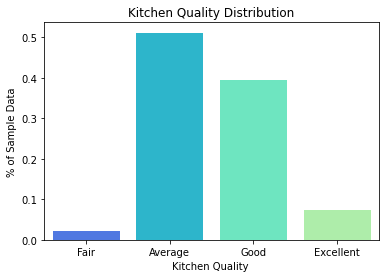

In [28]:
#plot distribution of kitchen quality feature in training data

sns.barplot(x=kitchen_qual_df['quality'], y=kitchen_qual_df['kitchen_qual']);
plt.title('Kitchen Quality Distribution')
plt.xlabel('Kitchen Quality ')
plt.ylabel('% of Sample Data');

From this graph we can see that less than 10% of the homes in the training dataset have a '5' for kitchen quality so a lot of people in the 3's and 4's might want to know this information before selling their home.

About 50% of the homes sold are currently only average kitchen quality!

In [29]:
#mean sales price by kitchen quality

avg_price_by_qual = round(houses2['saleprice'].groupby(houses2['kitchen_qual']).mean(),2)

avg_price_by_qual = pd.DataFrame(avg_price_by_qual)

avg_price_by_qual['quality'] = avg_price_by_qual.index.map({
    2 : 'Fair', 
    3 :'Average',
    4 : 'Good', 
    5 : 'Excellent'
})

avg_price_by_qual.head()

,saleprice,quality
kitchen_qual,,
2,100038.73,Fair
3,139604.98,Average
4,211156.23,Good
5,338988.14,Excellent


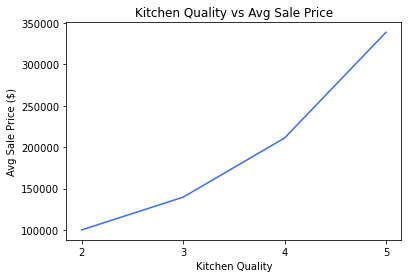

In [24]:
#plot kitchen quality vs avg price

sns.lineplot(x= avg_price_by_qual.index, y= avg_price_by_qual['saleprice']);
plt.title('Kitchen Quality vs Avg Sale Price')
plt.xlabel('Kitchen Quality')
plt.ylabel('Avg Sale Price ($)');
plt.locator_params(axis="x", nbins=4);


# referenced how to change amount of ticks in graph here
#https://www.kite.com/python/answers/how-to-change-the-number-of-ticks-on-a-plot-axis-in-matplotlib-in-python

This line graph of avg sales price vs each level of kitchen quality shows that price increases as the quality increases.

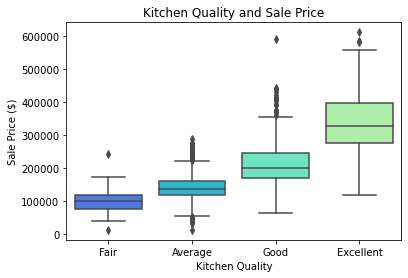

In [44]:
sns.boxplot(x=houses2['kitchen_qual'].sort_values(ascending=True).map({
    2 : 'Fair', 
    3 :'Average',
    4 : 'Good', 
    5 : 'Excellent'
}), 
            y=houses2['saleprice']);

plt.title('Kitchen Quality and Sale Price')
plt.xlabel('Kitchen Quality')
plt.ylabel('Sale Price ($)');

Similarly, this boxplot shows how the home price increases as the kitchen quality increases. Obviously, price is dependent on more than just the kitchen quality but this does seem to be a telling variable. 